# Loading the Data

In [2]:
# Importing the dataset and indexing its data
import json
from datasets import load_dataset

# Load the dataset, trust_remote_code=True is needed to load the dataset from the remote repository.
dataset = load_dataset('dataset-download.py', trust_remote_code=True) 

# Load the first 20 examples of the dataset
doc_list = [dataset['train'][:20]] 

# Extract just the captions to a variable
captions_list = doc_list[0]['en_captions']

# Sentences to use for the embeddings visualization
captions_list[1] # keyword "woman" (use this for now since it already has 6 sentences)

['The video starts with a title logo sequence.',
 ' A man and woman are in a living room demonstrating exercises.',
 ' The woman lays on the ground.',
 " The man starts pointing to different areas of the woman's body as she does an exercise.",
 ' The woman begins to do small sit ups.',
 ' The woman ends with a final title logo sequence.']

# Transformer Encoder

This notebook covers our understanding of the Tranformer Architecture as required in section 2.5


In [3]:
import torch

from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import logging
logging.set_verbosity_warning()

import numpy as np
import pprint

from bertviz import model_view, head_view

# Get the interactive Tools for Matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA



## Loading the Models


In [4]:
model_path ='deepset/roberta-base-squad2'

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained(model_path, output_hidden_states=True)
#model.eval() # Set the model to evaluation mode. This is important for models that have dropout layers, as it ensures that they are not used during inference.
# After loading the model, you can inspect its architecture. Typically, each model is composed by the embedding layer, the self-attention layers and the output layers. The output layer is always task specific. 
model

Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [5]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))
    
def display_scatterplot(model, words):

    if model.shape[1] == 2:
        twodim = model
    else:
        twodim = PCA().fit_transform(model)[:,:2]
    
    plt.style.use('ggplot')
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)


In [ ]:
sentence = "".join(captions_list[1])
inputs = tokenizer.encode_plus(sentence, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

In [8]:
with torch.no_grad():
    outputs = model(**inputs)

attention = outputs.attentions
hidden_states = outputs.hidden_states

## Visualization of embeddings / Contextual Embeddings

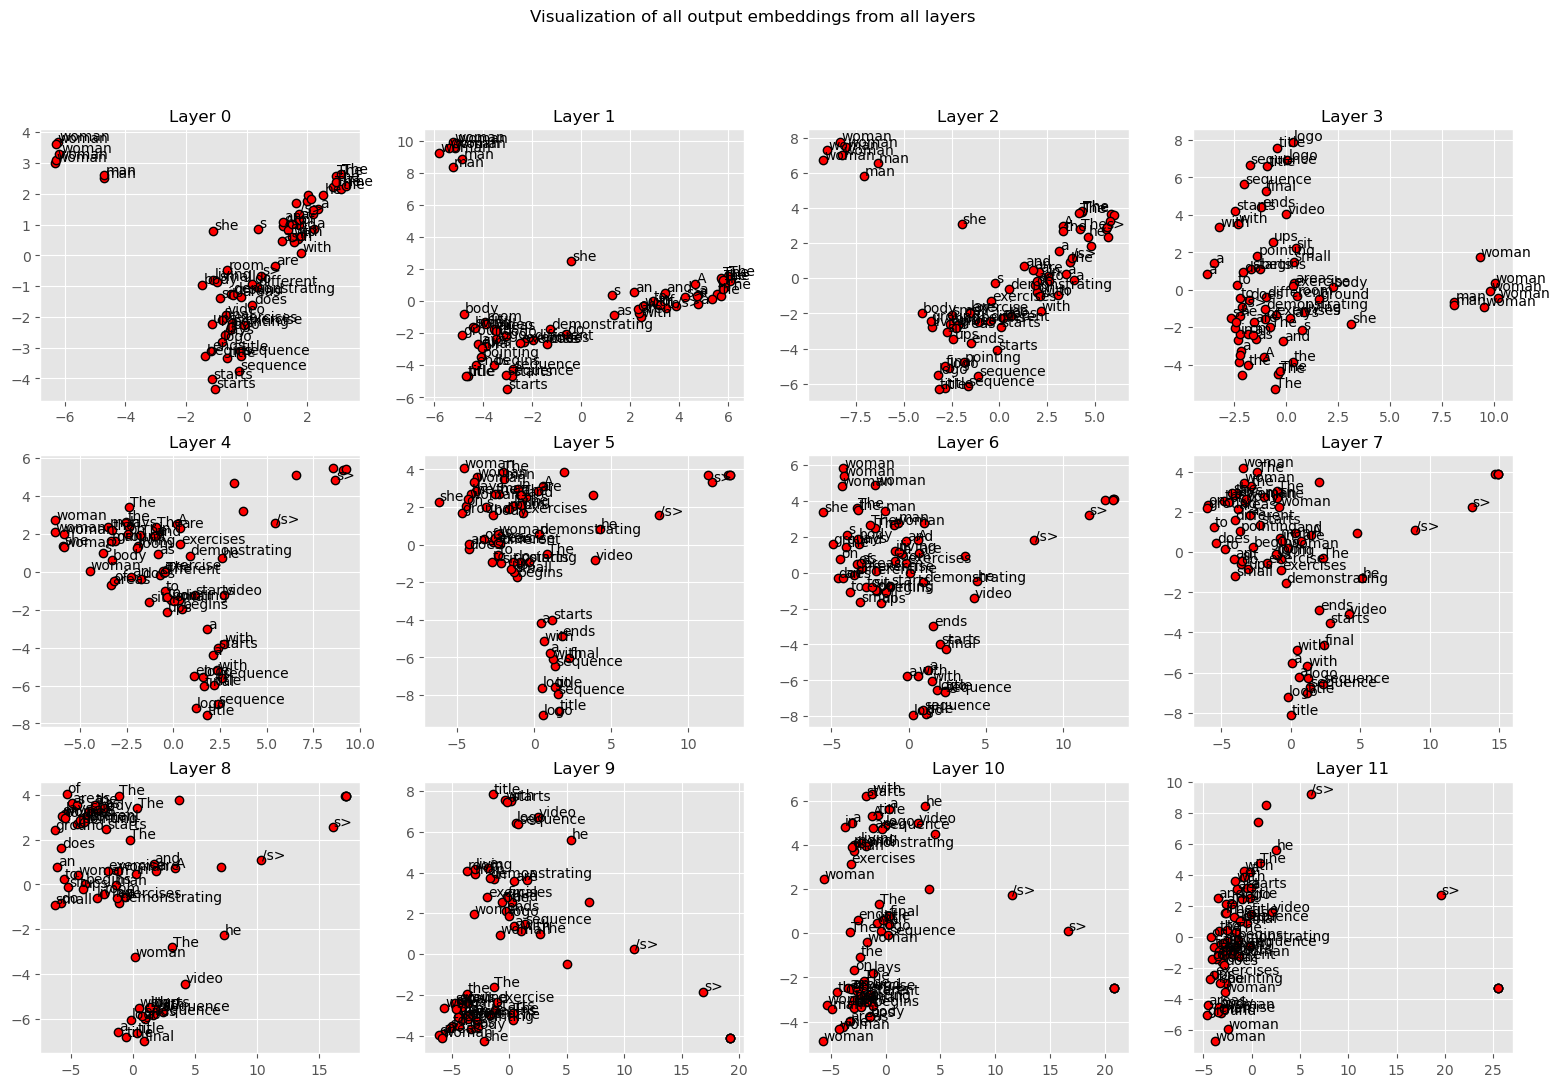

In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*4)
fig.set_figwidth(cols*4+3)
plt.rcParams.update({'font.size': 6})


layer = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        plt.rcParams.update({'font.size': 10})
        current_hidden_state = hidden_states[layer][0].detach().numpy()
        
        if current_hidden_state.shape[1] == 2:
            twodim = current_hidden_state
        else:
            twodim = PCA().fit_transform(current_hidden_state)[:,:2]

        plt.style.use('default') # https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
        im = ax.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
        for word, (x,y) in zip(tokens, twodim):
            ax.text(x+0.05, y+0.05, word[1:])
        
        # Show all ticks and label them with the respective list entries
        ax.set_title("Layer " + str(layer))
            
        # Loop over data dimensions and create text annotations.
        layer = layer + 1

fig.suptitle("Visualization of all output embeddings from all layers")
plt.show()

# Positional Embeddings

Consider a text encoder. Insert a sequence of text with the 
same word repeated 20 times. Visualize the embeddings and the distance across all 
tokens. Discuss what you observe.

In [10]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model_cross_encoder_path = 'cross-encoder/ms-marco-MiniLM-L-12-v2' # Cross-Encoder Model

tokenizer = AutoTokenizer.from_pretrained(model_cross_encoder_path)
config = AutoConfig.from_pretrained(model_cross_encoder_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained(model_cross_encoder_path, output_hidden_states=True)

# Tokenization of the repeated words sentence

In [ ]:
# Creating the sequence of text with the same word 20 times
repeated_words_sentence = "test " * 20

# Tokenizing the sentence
inputs = tokenizer(repeated_words_sentence, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Visualize the tokens (the first and last are "CLS" and "SEP")
print(tokens)

# Running the sentence through the model
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states

# Pick the layer to visualize the embeddings
#hidden_states[layer_N][0] is after token+position embeddings but before any transformer blocks
#hidden_states[layer_N][1] is after the first transformer layer

# Selecting the embedding layer
# hidden_states[layer_n][0] 
embeddings = hidden_states[0][0].numpy()

# Remove CLS and SEP tokens
# Very important for better visualization of the embeddings in matplot
filtered_tokens = []
filtered_embeddings = []

for token, emb in zip(tokens, embeddings):
    if token not in ['[CLS]', '[SEP]']:
        filtered_tokens.append(token)
        filtered_embeddings.append(emb)

print(filtered_tokens)

['[CLS]', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', '[SEP]']
['test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test', 'test']


# Distance across tokens

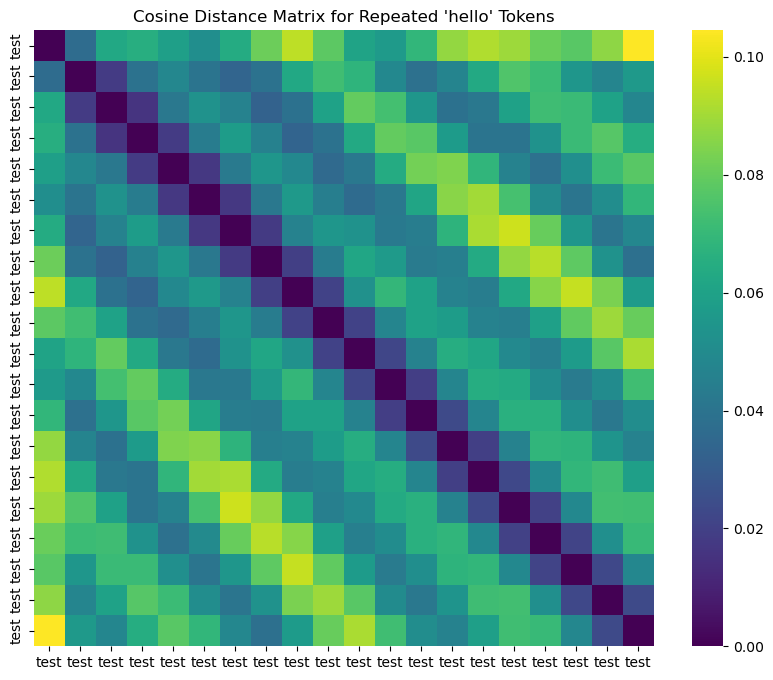

In [12]:
# Compute the distances
distances = cosine_distances(filtered_embeddings)

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(distances, xticklabels=filtered_tokens, yticklabels=filtered_tokens, cmap='viridis')
plt.title("Cosine Distance Matrix for Repeated 'hello' Tokens")
plt.show()

# Embeddings Visualization

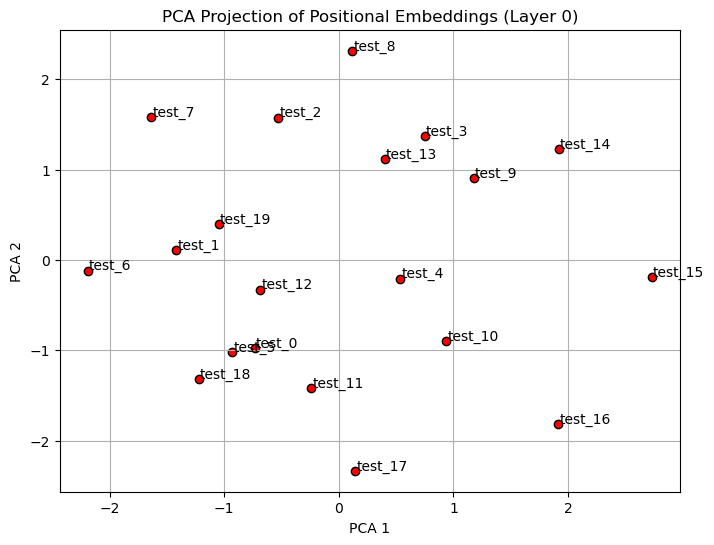

In [13]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(filtered_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='red', edgecolors='k')

for i, token in enumerate(filtered_tokens):
    plt.text(reduced_embeddings[i, 0]+0.01, reduced_embeddings[i, 1]+0.01, f"{token}_{i}")

plt.title("PCA Projection of Positional Embeddings (Layer 0)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


# Self-Attention

Examine the self-attention mecanism of a transformer cross-encoder.
Repeate with a dual encoder. Do a critical analysis of the observations

## Cross-Encoder Sections

In [63]:
# Here we are using the model above, a cross-encoder
model_cross_encoder_path = 'cross-encoder/ms-marco-MiniLM-L-12-v2' # Cross-Encoder Model

tokenizer_cross = AutoTokenizer.from_pretrained(model_cross_encoder_path)
config_cross = AutoConfig.from_pretrained(model_cross_encoder_path,  output_hidden_states=True, output_attentions=True)  
model_cross = AutoModel.from_pretrained(model_cross_encoder_path, output_hidden_states=True)

# Sentences definition and running them through the model
sentence_a = "Who is laying on the ground?"
sentence_b = captions_list[1][2] # "The woman lays on the ground"
inputs = tokenizer_cross.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0

# TO DO REMOVE CLS AND SEP TOKENS FOR VISUALIZATION ONLY
# Remove CLS and SEP tokens
# We also need to remove them from the attention variable
#for input in input_id_list:
#    if input in [101, 102]:
#        input_id_list.remove(input)

# Get the tokens
tokens = tokenizer_cross.convert_ids_to_tokens(input_id_list)

token_type_ids_list = inputs['token_type_ids'][0]

with torch.no_grad():
    outputs = model_cross(**inputs, output_attentions = True) # we need to have output_attentions = True, otherwise the cell below will not run

attention = outputs.attentions
hidden_states = outputs.hidden_states
#attention[layer][0] -> access each layer, doesn't go over 0 for the second bracker

In [64]:
# Token Specific Visualization of Self-Attention
#remove tokens from: input_ids, token_type_ids and attention_mask
#indexes: 0, 8, last
#print(attention)
#attention[1][0][0][0]  # attention values from token position 0 to all tokens in head 0, layer 1 → shape: [seq_len]

#print(tokens)
call_html()
head_view(attention, tokens)

<IPython.core.display.Javascript object>

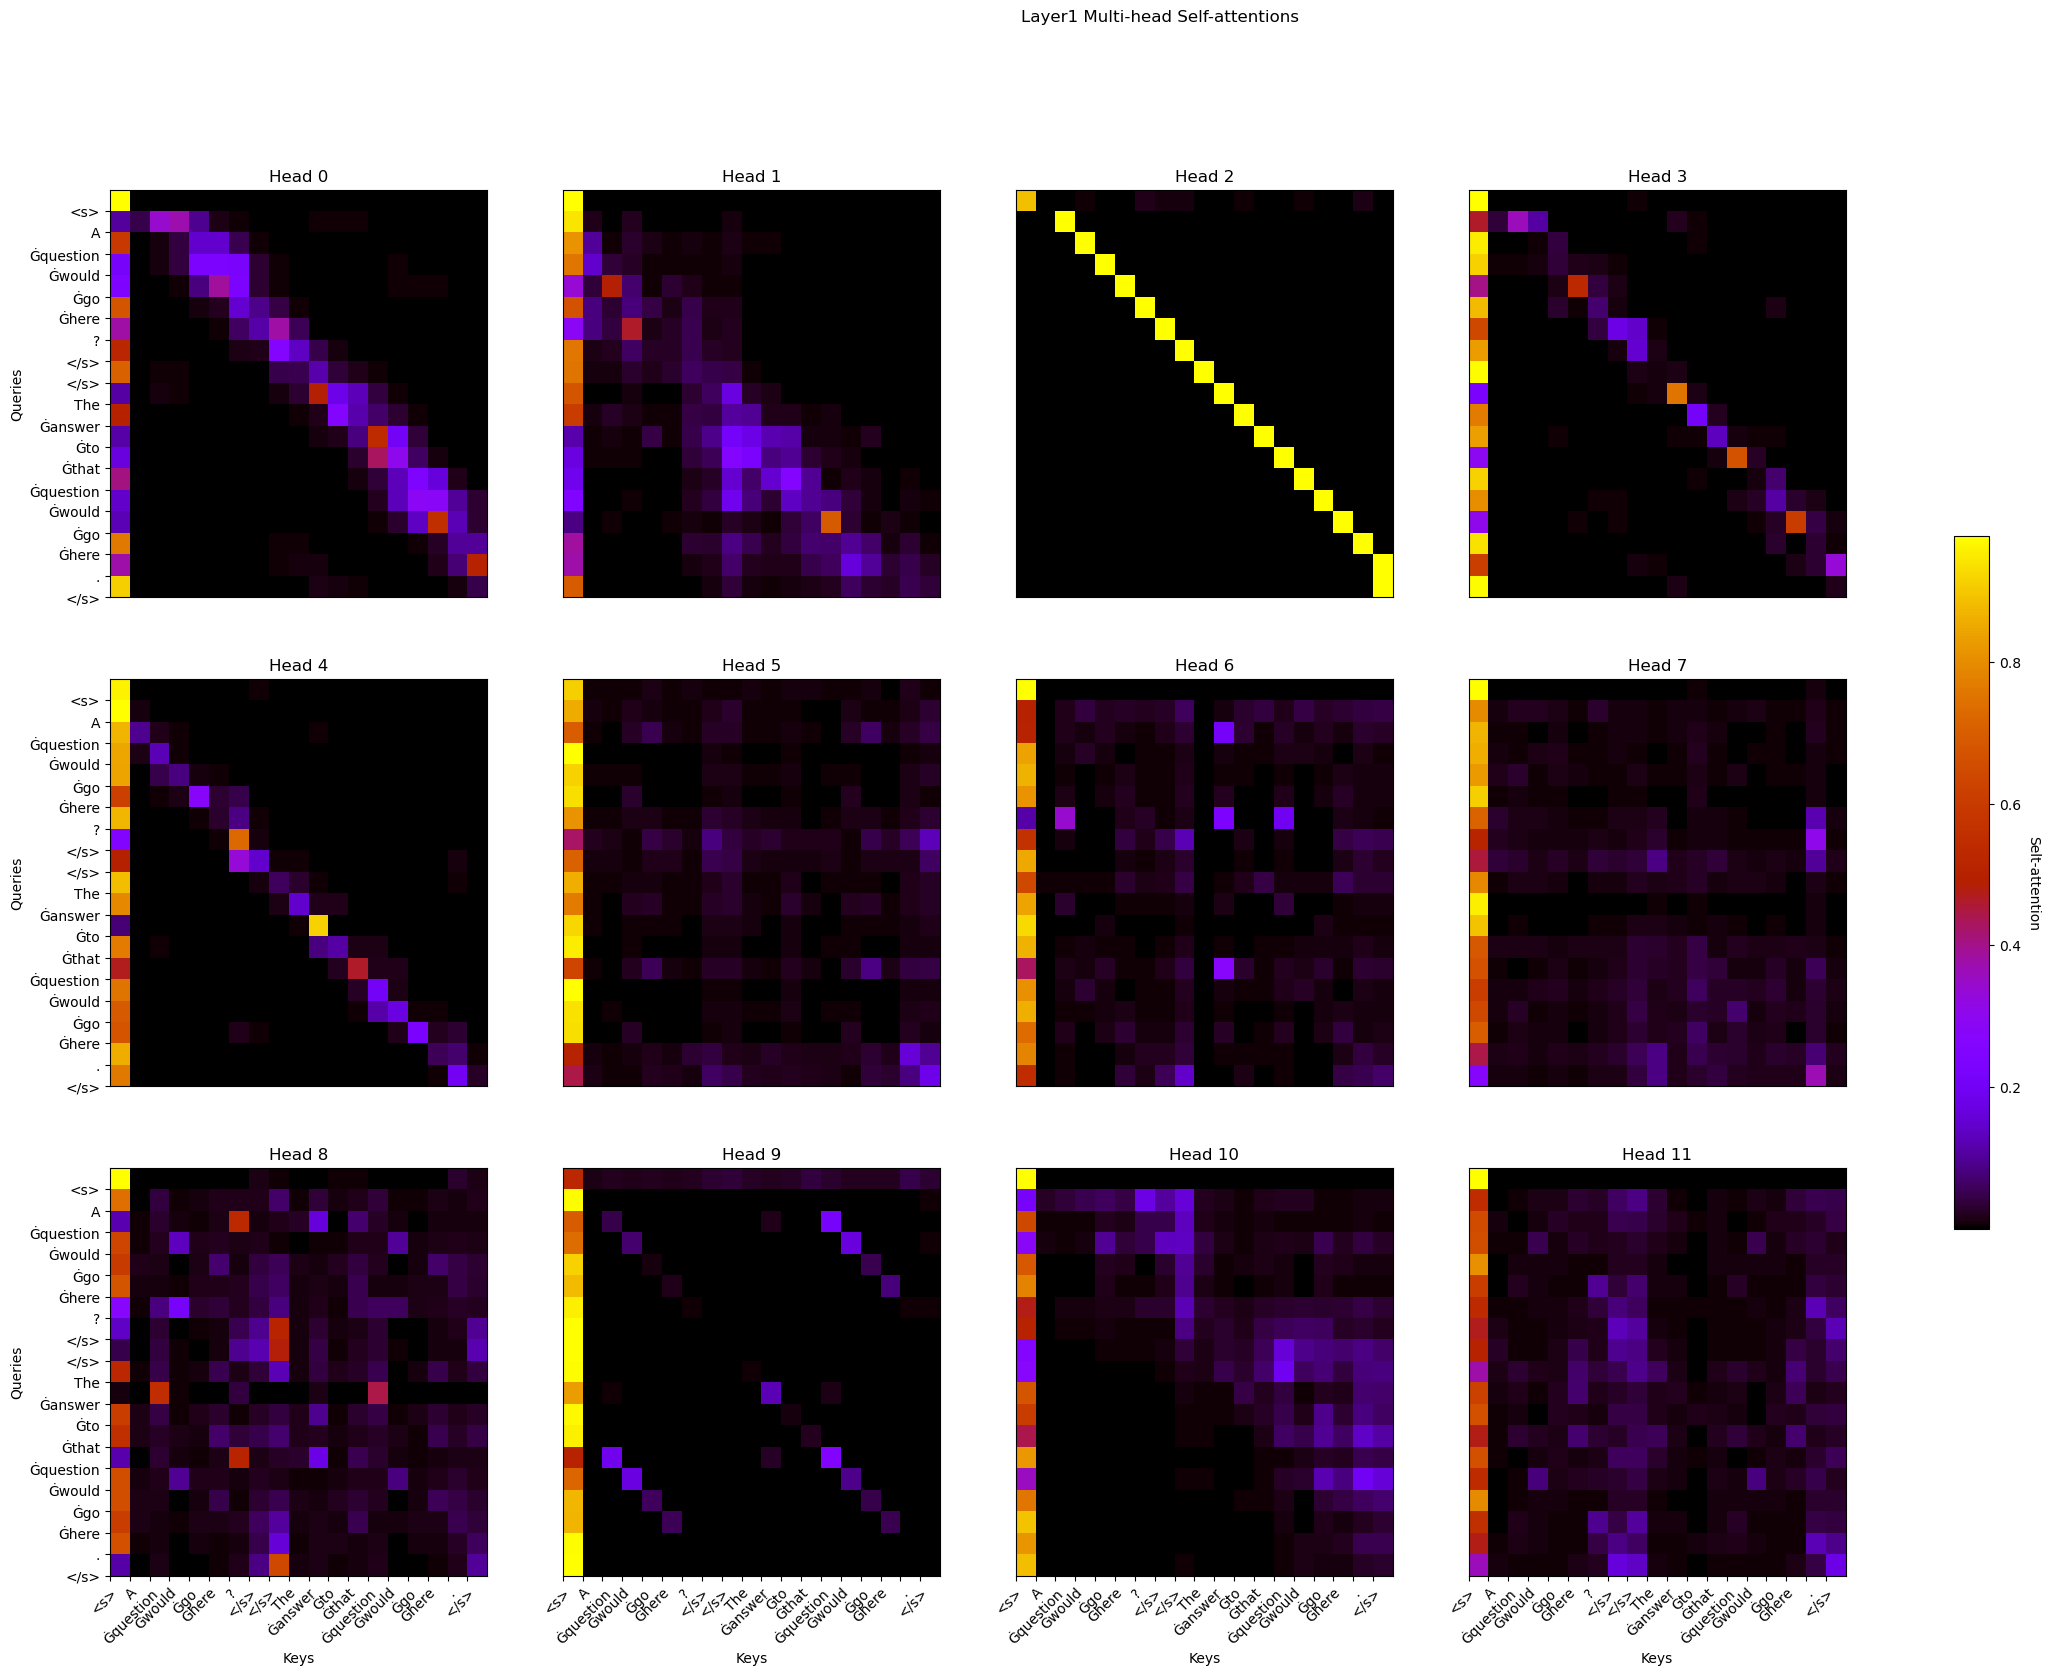

In [67]:
# Visualization of all the attention heads in one layer

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*6)
fig.set_figwidth(cols*6+4)
plt.rcParams.update({'font.size': 10})

j = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        sattention = attention[layer][0][j].numpy()
        sattention = np.flip(sattention, 0)
        
        plt.rcParams.update({'font.size': 10})

        im = ax.pcolormesh(sattention, cmap='gnuplot')

        # Show all ticks and label them with the respective list entries
        ax.set_title("Head " + str(j))
        ax.set_yticks(np.arange(len(tokens)))
        if c == 0:
            ax.set_yticklabels(reversed(tokens))
            ax.set_ylabel("Queries")
        else:
            ax.set_yticks([])

        ax.set_xticks(np.arange(len(tokens)))
        if r == rows-1:
            ax.set_xticklabels(tokens)
            ax.set_xlabel("Keys")
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
        else:
            ax.set_xticks([])

            
        # Loop over data dimensions and create text annotations.
        j = j + 1

fig.suptitle("Layer" + str(layer) + " Multi-head Self-attentions")
cbar = fig.colorbar(im, ax=ax_full, location='right', shrink=0.5)
cbar.ax.set_ylabel("Selt-attention", rotation=-90, va="bottom")
plt.show()

In [68]:
# Visualization of self-attention in all layers and heads
model_view(attention, tokens)

<IPython.core.display.Javascript object>

## Dual-Encoder Sections

In [62]:
# Here we are using the model above, a cross-encoder

model_dual_encoder_path = 'cross-encoder/ms-marco-MiniLM-L-12-v2' # Cross-Encoder Model

tokenizer_dual = AutoTokenizer.from_pretrained(model_dual_encoder_path)
config_dual = AutoConfig.from_pretrained(model_dual_encoder_path,  output_hidden_states=True, output_attentions=True)  
model_dual = AutoModel.from_pretrained(model_dual_encoder_path, output_hidden_states=True)

# Sentences definition and running them through the model
sentence_a = "A question would go here?"
sentence_b = "The answer to that question would go here."
inputs = tokenizer_dual.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer_dual.convert_ids_to_tokens(input_id_list)

with torch.no_grad():
    outputs = model_dual(**inputs, output_attentions = True) # we need to have output_attentions = True, otherwise the cell below will not run

attention = outputs.attentions
hidden_states = outputs.hidden_states

In [65]:
call_html()
head_view(attention, tokens)

<IPython.core.display.Javascript object>

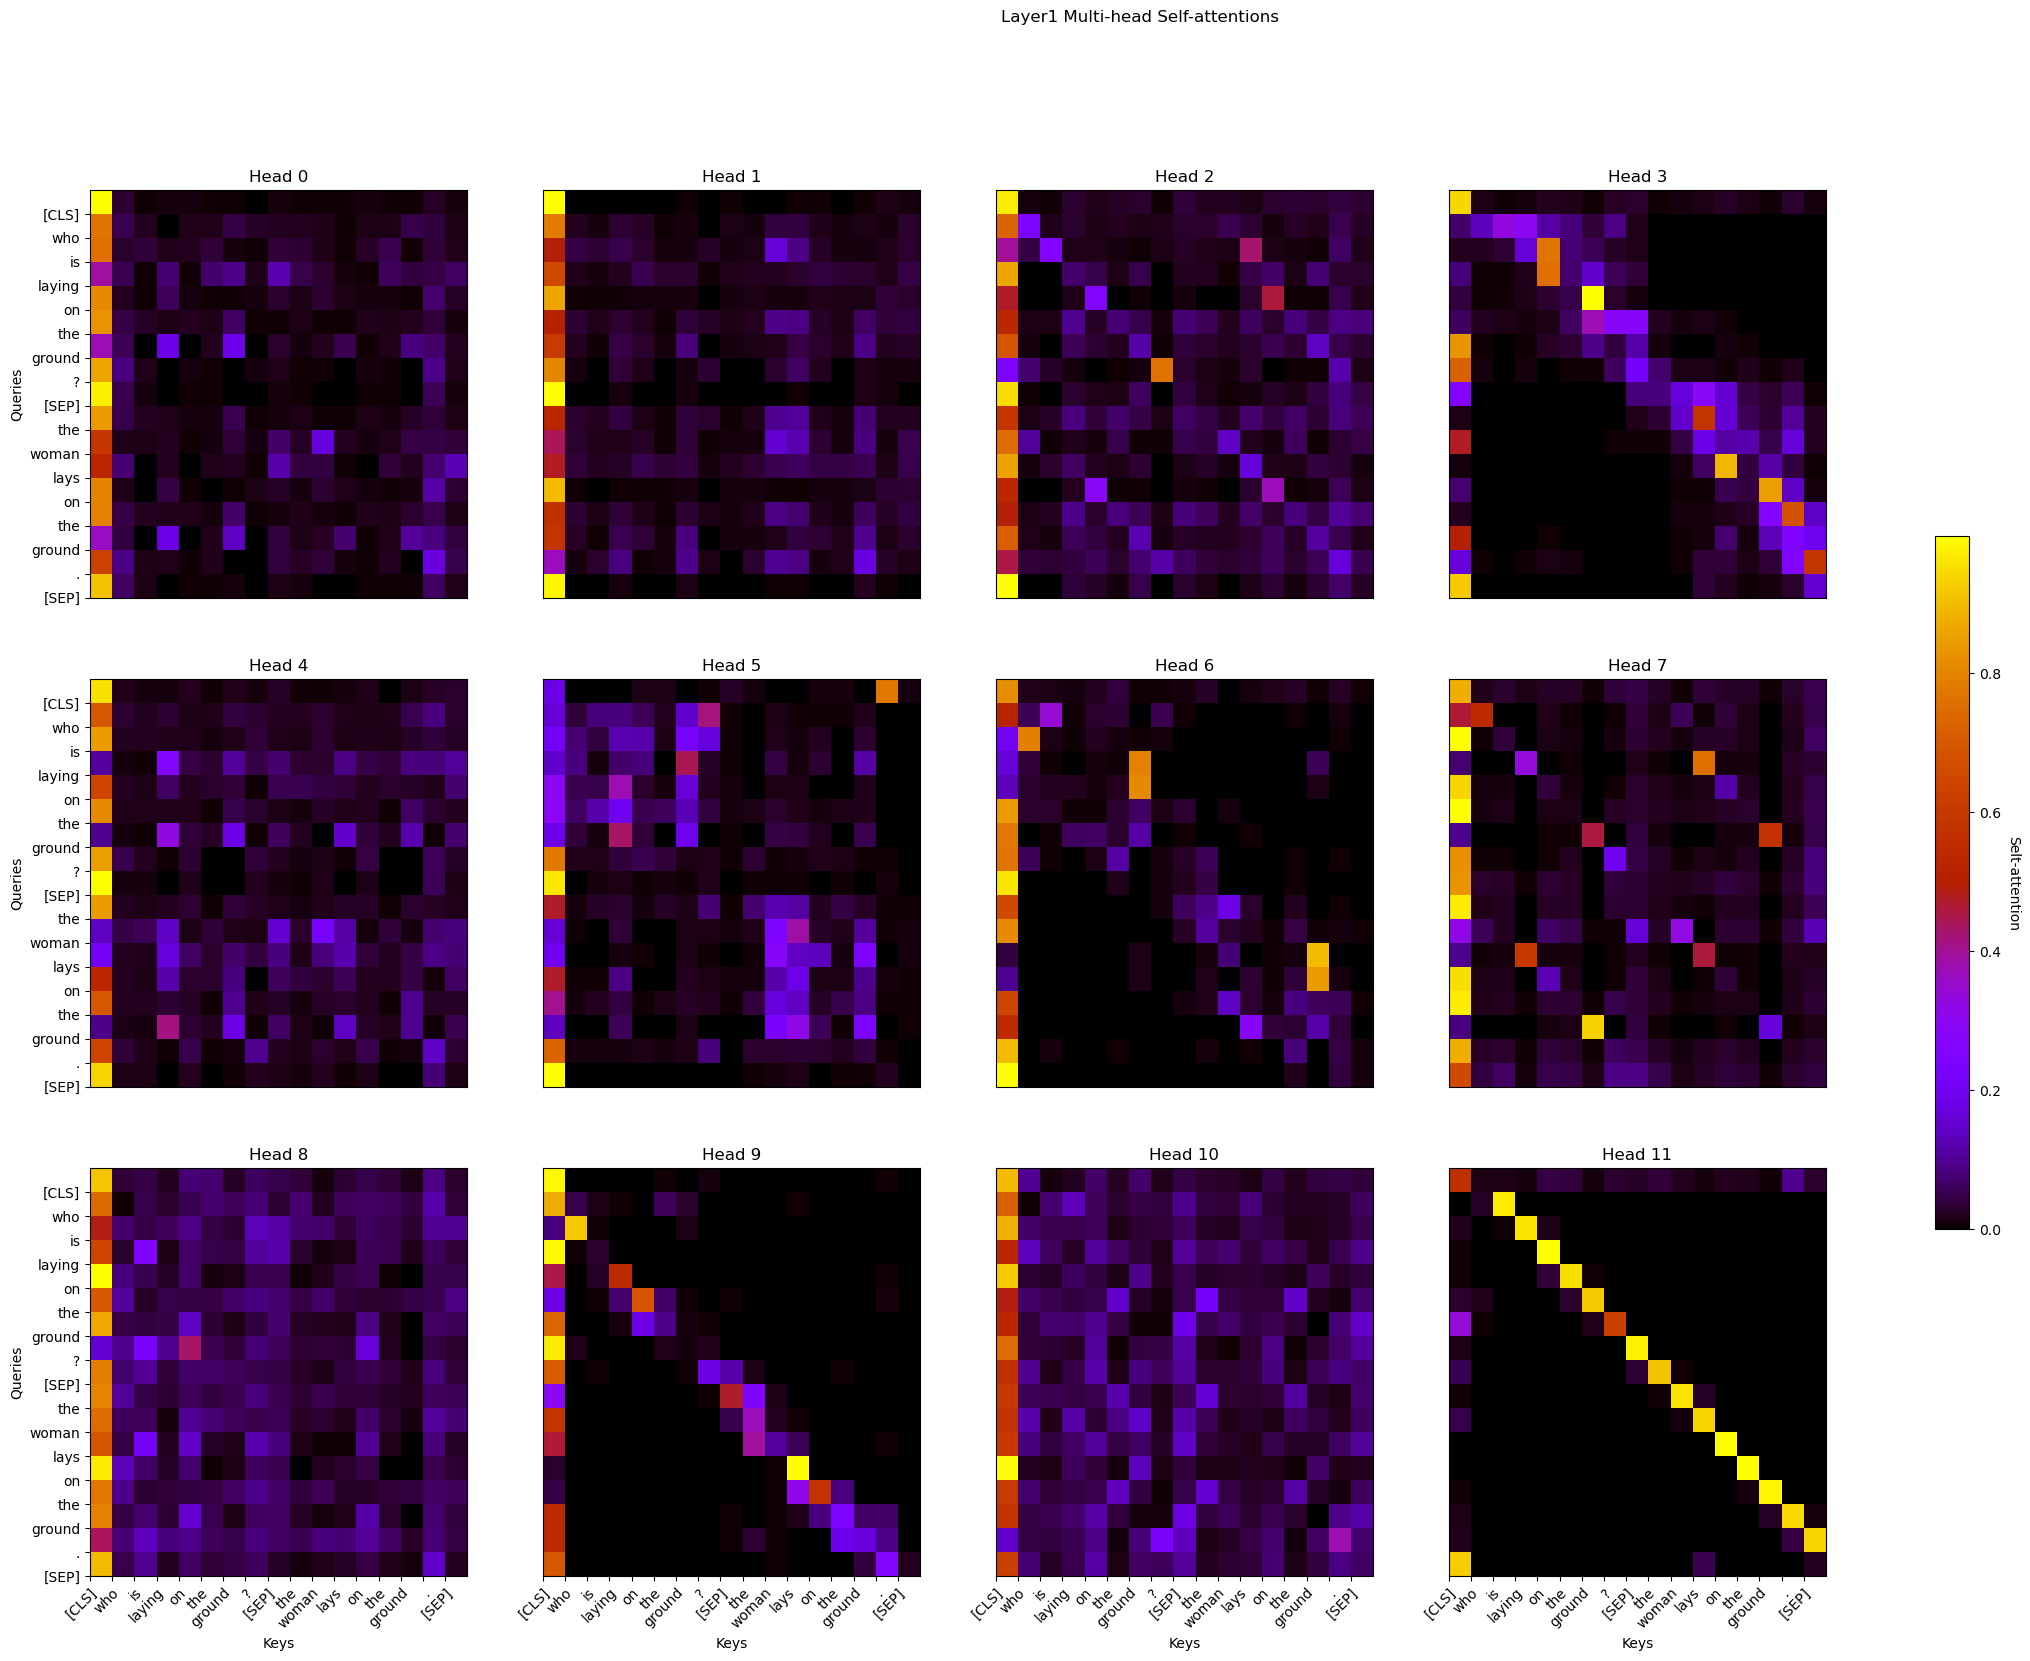

In [66]:
# Visualization of all the attention heads in one layer

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*6)
fig.set_figwidth(cols*6+4)
plt.rcParams.update({'font.size': 10})

j = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        sattention = attention[layer][0][j].numpy()
        sattention = np.flip(sattention, 0)
        
        plt.rcParams.update({'font.size': 10})

        im = ax.pcolormesh(sattention, cmap='gnuplot')

        # Show all ticks and label them with the respective list entries
        ax.set_title("Head " + str(j))
        ax.set_yticks(np.arange(len(tokens)))
        if c == 0:
            ax.set_yticklabels(reversed(tokens))
            ax.set_ylabel("Queries")
        else:
            ax.set_yticks([])

        ax.set_xticks(np.arange(len(tokens)))
        if r == rows-1:
            ax.set_xticklabels(tokens)
            ax.set_xlabel("Keys")
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
        else:
            ax.set_xticks([])

            
        # Loop over data dimensions and create text annotations.
        j = j + 1

fig.suptitle("Layer" + str(layer) + " Multi-head Self-attentions")
cbar = fig.colorbar(im, ax=ax_full, location='right', shrink=0.5)
cbar.ax.set_ylabel("Selt-attention", rotation=-90, va="bottom")
plt.show()

In [67]:
# Visualization of self-attention in all layers and heads
model_view(attention, tokens)

<IPython.core.display.Javascript object>

# Interpretability
Compute  the  attention  that  each  token  receives  on  each  layer  and 
visualize. How is this related to the final output of the model?

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get attention from model outputs
attention = outputs.attentions  # list of [batch_size, num_heads, seq_len, seq_len]

num_layers = len(attention)
num_heads = attention[0].shape[1]
seq_len = attention[0].shape[2]

# For each layer, compute total attention received by each token (average over heads and over sender tokens)
attention_received = []  # list of [seq_len] arrays, one per layer

for layer in range(num_layers):
    attn_matrix = attention[layer][0]  # [num_heads, seq_len, seq_len]
    attn_mean_heads = attn_matrix.mean(dim=0)  # [seq_len, seq_len], mean over heads
    attn_received_per_token = attn_mean_heads.sum(dim=0).cpu().numpy()  # sum over rows (attention *received* by each token)
    attention_received.append(attn_received_per_token)

# Convert to numpy array for heatmap plotting
attention_received = np.array(attention_received)  # [num_layers, seq_len]

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(attention_received, xticklabels=tokens, yticklabels=[f"Layer {i+1}" for i in range(num_layers)],
            cmap="YlGnBu", annot=True, fmt=".2f")
plt.xlabel("Tokens")
plt.ylabel("Transformer Layers")
plt.title("Attention Received by Each Token per Layer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
